# 0. Importar librerias

In [ ]:
# install the following if needed
# !pip install numpy==1.23.5 --force-reinstall
# pip install gensim nltk

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# 1. Cargar archivos csv con consultas y ejecutar limpieza preliminar

In [ ]:
df_consultas = pd.read_csv('mensajes_65fe1e0b76945.csv', encoding='utf-8')
df_consultas.head()

,c_id,usuario_uno,asunto,mensaje,notificar_usuario,fecha_creacion,fecha_actualizacion,leido
0,1,Admin,Información Edo cuenta,"[{""mensaje"":""Buenos d\u00edas cond\u00f3minos ...",1,2024-04-01 05:37:17,2024-04-01 05:37:17,0:Admin
1,2,6609cd517ef25,Captura de pago,"[{""mensaje"":""Como envío la captura del pago o ...",1,2024-04-01 07:07:47,2024-04-03 06:34:18,1
2,3,660ca61a969c2,Convenio de pago,"[{""mensaje"":""Buenas tardes, con el motivo que ...",1,2024-04-03 21:03:16,2024-04-04 01:15:58,1
3,4,66107d0c46ed6,Abono mes abril,"[{""mensaje"":""Hola ya te envié pago de abril lo...",1,2024-04-05 16:44:31,2024-04-22 23:35:12,1
4,5,6609da40d8cf8,Pagos,"[{""mensaje"":""Buenas noche ya subí todos mis co...",1,2024-04-05 20:54:39,2024-05-09 08:35:13,1


Se analizarán específicamente los mensajes, por lo cuale se extrae únicamente la columna con el mensaje

In [ ]:
raw_mensajes = df_consultas['mensaje']
raw_mensajes.head()

,mensaje
0,"[{""mensaje"":""Buenos d\u00edas cond\u00f3minos ..."
1,"[{""mensaje"":""Como envío la captura del pago o ..."
2,"[{""mensaje"":""Buenas tardes, con el motivo que ..."
3,"[{""mensaje"":""Hola ya te envié pago de abril lo..."
4,"[{""mensaje"":""Buenas noche ya subí todos mis co..."


El formato aparece como json por lo cual es necesario limpiar y extrar el mensaje, ya que aparece información adicional como la fecha y el ususario, esto se realizará con la librería de json y la función extract_message()

In [ ]:
# Function to extract and clean message

def extract_mensaje(json_str):
    try:
        parsed = json.loads(json_str)
        mensaje = parsed[0]["mensaje"]
        mensaje_clean = re.sub(r'<.*?>', '', mensaje)  # Remove <br /> tags
        return mensaje_clean
    except Exception as e:
        return f"Error: {e}"

* Este es un ejemplo de alguno de los mensajes previo al preprocesamiento

In [ ]:
raw_mensajes[0]

'[{"mensaje":"Buenos d\\u00edas cond\\u00f3minos <br \\/>En en transcurso de estos d\\u00edas quedar\\u00e1 cargada la informaci\\u00f3n sobre su estado de cuenta, por favor tener paciencia.<br \\/>Saludos","usuario":"Admin","fecha":"Enviado el 01 abril 2024 a las 05:37","leido":false}]'

* Este es el ejemplo del mensaje preprocesado

In [ ]:
my_json = extract_mensaje(raw_mensajes[0])
my_json

'Buenos días condóminos En en transcurso de estos días quedará cargada la información sobre su estado de cuenta, por favor tener paciencia.Saludos'

Una vez definida la función de preprocesamiento podemos generar nuestro dataset limpio sobre el cual analizaremos las diferentes peticiones de los usuarios de MiCoto

In [ ]:
clean_message = [extract_mensaje(mensaje) for mensaje in raw_mensajes]
clean_message[0:5]

['Buenos días condóminos En en transcurso de estos días quedará cargada la información sobre su estado de cuenta, por favor tener paciencia.Saludos',
 'Como envío la captura del pago o como sabrán q ya pagué ? Supongo tiene q ser desde la App o me indican ? Pofavor ',
 'Buenas tardes, con el motivo que no he estado viviendo en el eden plus, pero veo que tengo muchos pagos atrasados hay algún tipo de convenio?',
 'Hola ya te envié pago de abril los 300',
 'Buenas noche ya subí todos mis comprobantes de pagos de mantenimiento al igual que la unidad ']

* Este es el dataframe resultante después de haber ejecutado la limpieza

In [ ]:
df_clean_mensajes = pd.DataFrame({
      'mensaje_raw': raw_mensajes,
      'mensaje_clean': clean_message
}
)
df_clean_mensajes

,mensaje_raw,mensaje_clean
0,"[{""mensaje"":""Buenos d\u00edas cond\u00f3minos ...",Buenos días condóminos En en transcurso de est...
1,"[{""mensaje"":""Como envío la captura del pago o ...",Como envío la captura del pago o como sabrán q...
2,"[{""mensaje"":""Buenas tardes, con el motivo que ...","Buenas tardes, con el motivo que no he estado ..."
3,"[{""mensaje"":""Hola ya te envié pago de abril lo...",Hola ya te envié pago de abril los 300
4,"[{""mensaje"":""Buenas noche ya subí todos mis co...",Buenas noche ya subí todos mis comprobantes de...
...,...,...
150,"[{""mensaje"":""Buen día.<br /><br />Subí mis dat...","Buen día.Subí mis datos para facturar, le doy ..."
151,"[{""mensaje"":""Actualizar mis pagos siguen en ve...",Actualizar mis pagos siguen en verificación
152,"[{""mensaje"":""Buenas tardes. Nos gustaría apart...",Buenas tardes. Nos gustaría apartar la palapa ...
153,"[{""mensaje"":""EE1 #202"",""usuario"":""667f5b452646...",EE1 #202


* Se puede observar que tenemos stopwords que pueden afectar el análisis por lo cual se generará un columna adicional con el mensaje sin stopwords, para ello generaremos una función adicional de limpieza de texto

In [ ]:
# Download Spanish stopwords if you haven't already
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# custom stopwords
custom_stopwords = spanish_stopwords.union({
    'buenas','buena','tarde','tardes','hola','favor','día','bueno','dia'
    ,'buenos','enero','febrero','marzo','abril','mayo','junio','julio'
    ,'agosto','septiembre','octubre','noviembre','diciembre','mes','Buenas'
    ,'Hola','hola','Buen','2024','días','si','sí','tardes,','subir','aún'
    ,'Saludos','pueden'
})


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean_text(text):
  if pd.isna(text):
    return ""
  # se convierte todo a minúsucula y se elimina signos de puntuación y digitos
  text = re.sub(r'[^\w\s]', '', text.lower())
  words = text.split()

  # se eliminan stopworrd
  words = [word for word in words if word not in custom_stopwords]
  return ' '.join(words)

* Finalmente se construye el dataframe de salida sobre el cual realizaremos el anális exploratorio como wordclouds y LDA para identificación de tópicos

In [ ]:
# mensaje sin stopwords
df_clean_mensajes["mensaje_sin_stopwords"] = df_clean_mensajes["mensaje_clean"] .apply(clean_text)
df_clean_mensajes.head()


df_clean_mensajes['asunto'] = df_consultas['asunto']
df_clean_mensajes.head()

,mensaje_raw,mensaje_clean,mensaje_sin_stopwords,asunto
0,"[{""mensaje"":""Buenos d\u00edas cond\u00f3minos ...",Buenos días condóminos En en transcurso de est...,condóminos transcurso quedará cargada informac...,Información Edo cuenta
1,"[{""mensaje"":""Como envío la captura del pago o ...",Como envío la captura del pago o como sabrán q...,envío captura pago sabrán q pagué supongo q se...,Captura de pago
2,"[{""mensaje"":""Buenas tardes, con el motivo que ...","Buenas tardes, con el motivo que no he estado ...",motivo viviendo eden plus veo pagos atrasados ...,Convenio de pago
3,"[{""mensaje"":""Hola ya te envié pago de abril lo...",Hola ya te envié pago de abril los 300,envié pago 300,Abono mes abril
4,"[{""mensaje"":""Buenas noche ya subí todos mis co...",Buenas noche ya subí todos mis comprobantes de...,noche subí comprobantes pagos mantenimiento ig...,Pagos


# 2. Análisis exploratorio de datos: mensaje


# Wordcloud

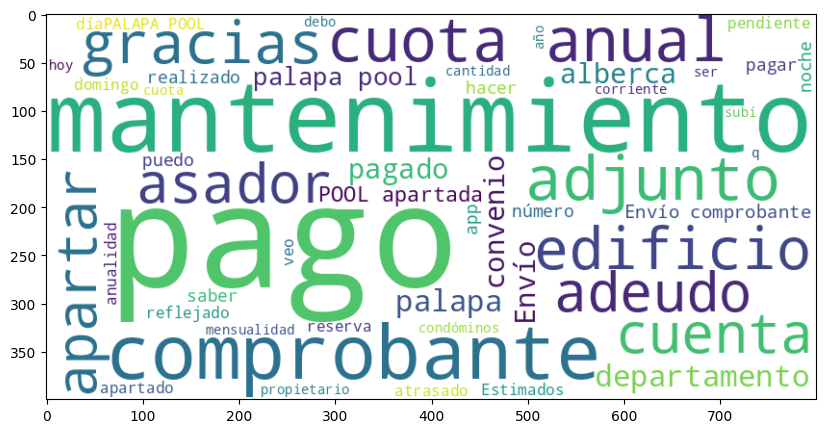

In [ ]:
# Combinar todo el texto en un string
text = ' '.join(df_clean_mensajes['mensaje_clean'].dropna())

# Crear wordcloud

wordcloud_mensaje = WordCloud(width=800
  ,height=400
  ,background_color='white'
  ,stopwords= custom_stopwords
  ,max_words = 50
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mensaje, interpolation='bilinear')

# Most commond words

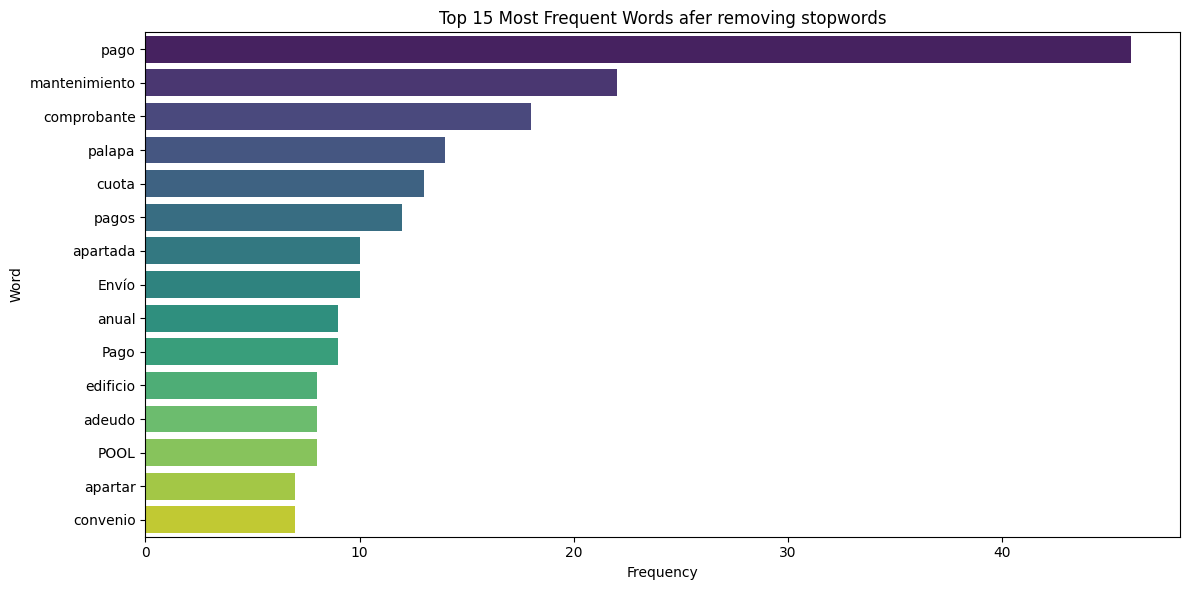

In [ ]:
# Combine all words from the cleaned column
all_words = ' '.join(df_clean_mensajes["mensaje_clean"].dropna()).split()

# Filter out stopwords
filtered_words = [word for word in all_words if word not in custom_stopwords]

# Count word frequencies
word_freq = Counter(filtered_words)

# Get the top N most common words
top_n = 15
common_words = word_freq.most_common(top_n)

# Create a DataFrame for plotting
freq_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=freq_df, palette='viridis')
plt.title(f'Top {top_n} Most Frequent Words afer removing stopwords')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# 3. Análisis exploratorio de datos: Asunto

# Wordcloud

In [ ]:
# mensaje sin stopwords
df_clean_mensajes["asunto_clean"] = df_clean_mensajes["asunto"] .apply(clean_text)
df_clean_mensajes.head()

,mensaje_raw,mensaje_clean,mensaje_sin_stopwords,asunto,asunto_clean
0,"[{""mensaje"":""Buenos d\u00edas cond\u00f3minos ...",Buenos días condóminos En en transcurso de est...,condóminos transcurso quedará cargada informac...,Información Edo cuenta,información edo cuenta
1,"[{""mensaje"":""Como envío la captura del pago o ...",Como envío la captura del pago o como sabrán q...,envío captura pago sabrán q pagué supongo q se...,Captura de pago,captura pago
2,"[{""mensaje"":""Buenas tardes, con el motivo que ...","Buenas tardes, con el motivo que no he estado ...",motivo viviendo eden plus veo pagos atrasados ...,Convenio de pago,convenio pago
3,"[{""mensaje"":""Hola ya te envié pago de abril lo...",Hola ya te envié pago de abril los 300,envié pago 300,Abono mes abril,abono
4,"[{""mensaje"":""Buenas noche ya subí todos mis co...",Buenas noche ya subí todos mis comprobantes de...,noche subí comprobantes pagos mantenimiento ig...,Pagos,pagos


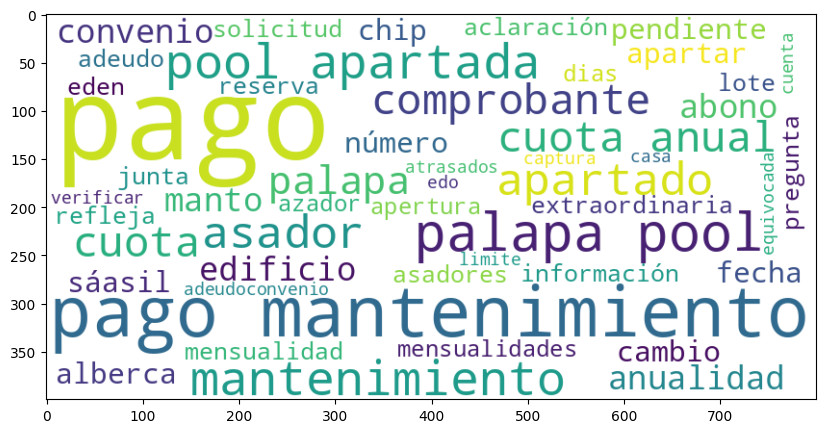

In [ ]:
# Combinar todo el texto en un string
text = ' '.join(df_clean_mensajes['asunto_clean'].dropna())

# Crear wordcloud

wordcloud_mensaje = WordCloud(width=800
  ,height=400
  ,background_color='white'
  ,stopwords= custom_stopwords
  ,max_words = 50
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mensaje, interpolation='bilinear')

# Most commond words

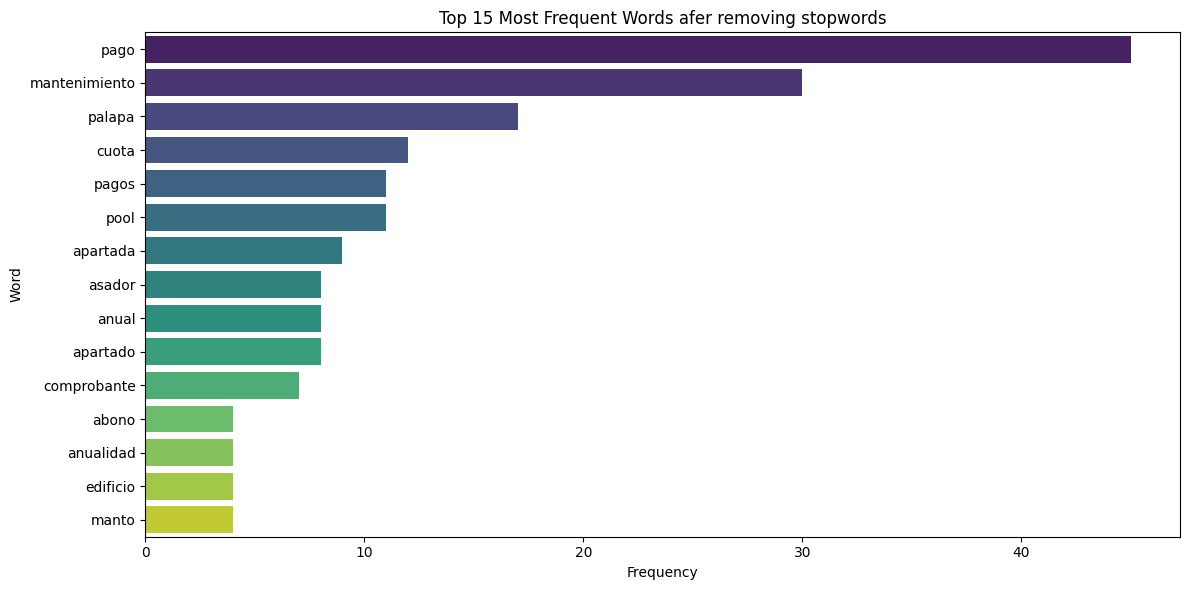

In [ ]:
# Combine all words from the cleaned column
all_words = ' '.join(df_clean_mensajes["asunto_clean"].dropna()).split()

# Filter out stopwords
filtered_words = [word for word in all_words if word not in custom_stopwords]

# Count word frequencies
word_freq = Counter(filtered_words)

# Get the top N most common words
top_n = 15
common_words = word_freq.most_common(top_n)

# Create a DataFrame for plotting
freq_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=freq_df, palette='viridis')
plt.title(f'Top {top_n} Most Frequent Words afer removing stopwords')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# 4. Análisis de Tópicos LDI sobre mensaje

In [ ]:
# Tokenize each message (must be a list of words per document)
texts = df_clean_mensajes["mensaje_sin_stopwords"].dropna().apply(lambda x: x.split()).tolist()
texts[0:2]

[['condóminos',
  'transcurso',
  'quedará',
  'cargada',
  'información',
  'cuenta',
  'tener',
  'pacienciasaludos'],
 ['envío',
  'captura',
  'pago',
  'sabrán',
  'q',
  'pagué',
  'supongo',
  'q',
  'ser',
  'app',
  'indican',
  'pofavor']]

In [ ]:
from gensim import corpora

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(texts)

# Filter out extremes (very rare or very common words)
dictionary.filter_extremes(no_below = 10,no_above=0.6)

# Create the Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim.models import LdaModel

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,       # You can tune this
    passes=10,          # More passes = better convergence
    random_state=42
)

In [ ]:
# Print the top words per topic
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"🔹 Topic {idx}: {topic}")

🔹 Topic 0: 0.289*"palapa" + 0.256*"pool" + 0.254*"buen" + 0.172*"apartada" + 0.004*"pago"
🔹 Topic 1: 0.262*"pago" + 0.252*"mantenimiento" + 0.215*"cuota" + 0.170*"anual" + 0.065*"envío"
🔹 Topic 2: 0.304*"pago" + 0.283*"comprobante" + 0.165*"adjunto" + 0.145*"envío" + 0.077*"mantenimiento"
🔹 Topic 3: 0.665*"pagos" + 0.103*"mantenimiento" + 0.092*"buen" + 0.048*"comprobante" + 0.034*"pago"
🔹 Topic 4: 0.889*"pago" + 0.012*"palapa" + 0.012*"pool" + 0.010*"mantenimiento" + 0.010*"apartada"


In [ ]:
# Get dominant topic for each document
def get_dominant_topic(doc_bow):
    topics = lda_model.get_document_topics(doc_bow)
    return sorted(topics, key=lambda x: -x[1])[0][0] if topics else None

df_clean_mensajes["dominant_topic"] = [get_dominant_topic(doc) for doc in corpus]

In [ ]:
df_clean_mensajes

,mensaje_raw,mensaje_clean,mensaje_sin_stopwords,asunto,asunto_clean,dominant_topic
0,"[{""mensaje"":""Buenos d\u00edas cond\u00f3minos ...",Buenos días condóminos En en transcurso de est...,condóminos transcurso quedará cargada informac...,Información Edo cuenta,información edo cuenta,0
1,"[{""mensaje"":""Como envío la captura del pago o ...",Como envío la captura del pago o como sabrán q...,envío captura pago sabrán q pagué supongo q se...,Captura de pago,captura pago,2
2,"[{""mensaje"":""Buenas tardes, con el motivo que ...","Buenas tardes, con el motivo que no he estado ...",motivo viviendo eden plus veo pagos atrasados ...,Convenio de pago,convenio pago,3
3,"[{""mensaje"":""Hola ya te envié pago de abril lo...",Hola ya te envié pago de abril los 300,envié pago 300,Abono mes abril,abono,4
4,"[{""mensaje"":""Buenas noche ya subí todos mis co...",Buenas noche ya subí todos mis comprobantes de...,noche subí comprobantes pagos mantenimiento ig...,Pagos,pagos,3
...,...,...,...,...,...,...
150,"[{""mensaje"":""Buen día.<br /><br />Subí mis dat...","Buen día.Subí mis datos para facturar, le doy ...",buen díasubí datos facturar doy guardar moment...,Facturación,facturación,0
151,"[{""mensaje"":""Actualizar mis pagos siguen en ve...",Actualizar mis pagos siguen en verificación,actualizar pagos siguen verificación,Actualizar mis pagos,actualizar pagos,3
152,"[{""mensaje"":""Buenas tardes. Nos gustaría apart...",Buenas tardes. Nos gustaría apartar la palapa ...,gustaría apartar palapa azadores 28 partir 5,Apartar palapa y un azador,apartar palapa azador,0
153,"[{""mensaje"":""EE1 #202"",""usuario"":""667f5b452646...",EE1 #202,ee1 202,Pago de anualidad,pago anualidad,0
